In [56]:
import sys
sys.path.insert(0,'..')

import pickle
from mmdetection.mmdet.apis import init_detector, inference_detector, show_result
from tqdm import tqdm_notebook
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

In [57]:
# CONSTANTS
prediction_file_path = 'preds.txt'
ground_truth_file_path = 'ground-truth.txt'
# anns = pickle.load(open('../../data/t3-data/splits/all/test.pkl', 'rb'))
anns = pickle.load(open('../../data/t3-data/only_yaya_test_frames.pkl', 'rb'))

# config_file = '../mmdetection/configs/faster_rcnn_r50_fpn_1x.py'
# checkpoint_file = '../mmdetection/work_dirs/old_workdir/faster_rcnn_r50_fpn_1x_visdrone/epoch_1.pth'

# config_file = '../mmdetection/configs/faster_rcnn_r50_fpn_1x.py'
# checkpoint_file = '../mmdetection/work_dirs/faster_rcnn_r50_fpn_1x_mix/epoch_4.pth'

# config_file = '../mmdetection/configs/faster_rcnn_r50_fpn_1x.py'
# checkpoint_file = '../mmdetection/work_dirs/old_workdir/faster_rcnn_r50_fpn_1x_visdrone_pretrained/epoch_14.pth'

# config_file = '../../src/configs/libra_rcnn/libra_retinanet_r50_fpn_1x.py'
# checkpoint_file = '../mmdetection/work_dirs/libra_retinanet_r50_fpn_1x/epoch_2.pth'

config_file = '../configs/guided_anchoring/ga_retinanet_x101_32x4d_fpn_1x.py'
checkpoint_file = '../../models/work_dirs/ga_retinanet_x101_32x4d_fpn_1x/latest.pth'


# config_file = '../mmdetection/configs/retinanet_r50_fpn_1x.py'
# checkpoint_file = '../mmdetection/work_dirs/retinanet_r50_fpn_1x_visdrone/epoch_2.pth'

# config_file = '../../src/configs/cascade_rcnn_r50_fpn_1x.py'
# checkpoint_file = '../../models/work_dirs/cascade_rcnn_r50_fpn_1x-all/latest.pth'

# config_file = '../mmdetection/configs/faster_rcnn_r101_fpn_1x.py'
# checkpoint_file = '../mmdetection/work_dirs/old_workdir/faster_rcnn_r101_fpn_1x/epoch_15.pth'

# config_file = '../../models/google-cloud-models/cascade-t3-vis/config.py'
# checkpoint_file = '../../models/google-cloud-models/cascade-t3-vis/epoch_1.pth'



In [59]:
results = []
model = init_detector(config_file, checkpoint_file, device='cuda:0')


img_list = ['../../data/t3-data/' + ann['filename'] for ann in anns]

img_list = [f for f in glob('../../data/ktr-test/test/B23072019_V1_K1/**.jpg')]
# img_list = ['../../data/ktr-test/test/B23072019_V1_K1/frame3500.jpg']

for img in tqdm_notebook(img_list):
#     if 'T190619_V1_K1/frame15748.jpg' not in img:
#         continue
    # inference on single image
    results.append(inference_detector(model, img))

In [51]:
[i for i,r in enumerate(results) if len(r[0]) > 0]

[]

In [77]:
img_list[7]

'../../data/ktr-test/test/B23072019_V1_K1/frame2009.jpg'

In [76]:
print(results[7])

[array([[1.21537361e+02, 4.85048798e+02, 1.48613190e+02, 5.23303162e+02,
        2.52135456e-01],
       [1.12694855e+02, 4.91337341e+02, 1.38322968e+02, 5.25042603e+02,
        1.01460010e-01],
       [2.34018204e+02, 2.56781097e+02, 2.55687958e+02, 2.90683014e+02,
        7.75477514e-02]], dtype=float32)]


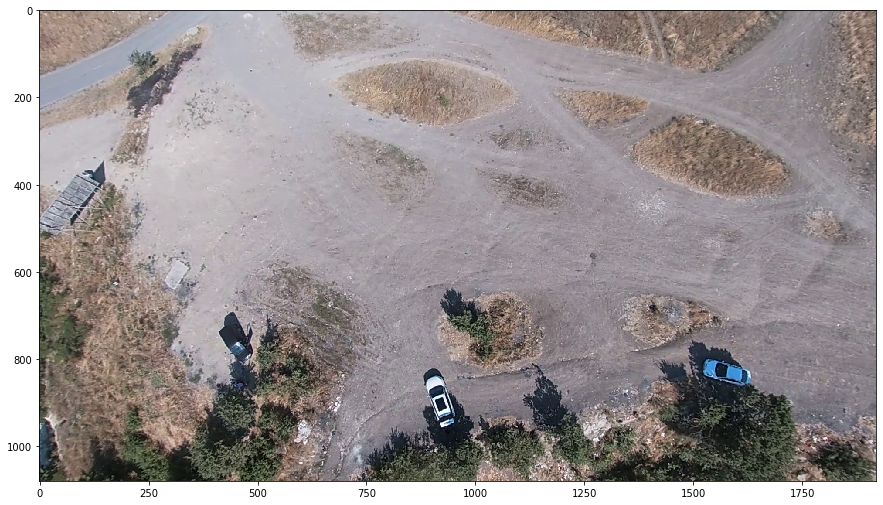

In [45]:
N = 0 # nth image to be shown
threshold = 0.10


%matplotlib inline
import cv2
import colorsys
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,12) # w, h

# img = image.imread('../data/external/visdrone/train/sequences/uav0000243_00001_v/0000690.jpg').asnumpy()

_GRAY = (218, 227, 218)
_GREEN = (18, 127, 15)
_WHITE = (255, 255, 255)
font_scale=0.85

im = cv2.imread(img_list[N])


for i in filter(lambda x: x[-1] >= threshold, results[N][0]):
    cv2.rectangle(im, (int(i[0]), int(i[1])),
                     (int(i[2]), int(i[3])), _GREEN, 2)
    font = cv2.FONT_HERSHEY_DUPLEX
    ((txt_w, txt_h), _) = cv2.getTextSize('person', font, font_scale, 1)
    back_tl = int(i[0]), int(i[1] - 1.3 * txt_h)
    back_br = int(i[0] + txt_w), int(i[1])
    cv2.rectangle(im, back_tl, back_br, _GRAY, -1)
    
    cv2.rectangle(im, back_tl, back_br, _GRAY, -1)



    txt_tl = int(i[0]), int(i[1]) - int(0.3 * txt_h)

    cv2.putText(im, 'person: '+ str(i[4]) , txt_tl,
                             cv2.FONT_HERSHEY_DUPLEX, font_scale, _WHITE, 1, cv2.LINE_AA)


im2 = im[:,:,::-1]
plt.imshow(im2)

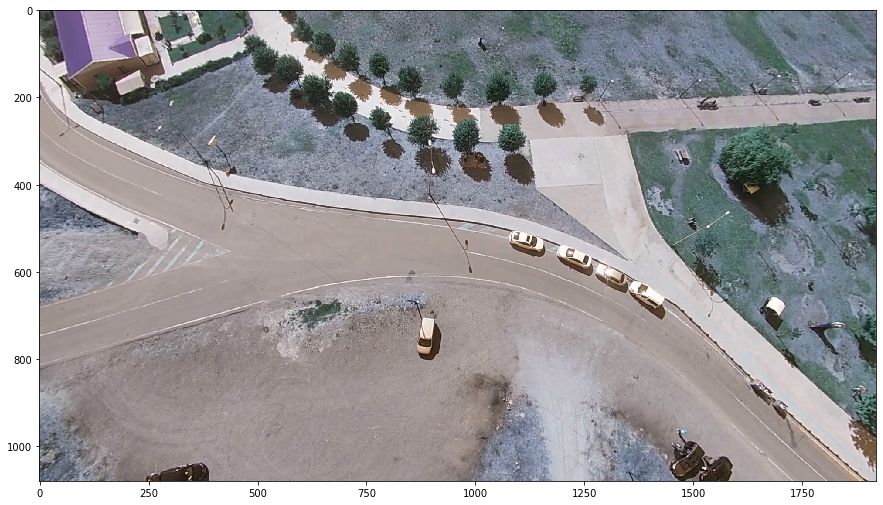

In [39]:
plt.imshow(cv2.imread(img_list[N]))

In [31]:
# PREDS.TXT
thres = [0.1]
with open(prediction_file_path, 'w+') as f:
    for img_path, img_preds in zip(img_list, results):
        line = '/'.join(img_path.split('/')[-2:])
        for i, preds in enumerate(img_preds[:2]):
            for bbox in filter(lambda x: x[-1] >= thres[i], preds):
                line += ",{},{},{},{},{}".format(*bbox[:-1], i)
        f.write(line)
        f.write('\n')

In [32]:
# GROUND TRUTH
with open(ground_truth_file_path, 'w+') as f:
    for img in anns:
        line = '/'.join(img['filename'].split('/')[-2:])
        for i, bbox in enumerate(img['ann']['bboxes']):
            line += ",{},{},{},{},{}".format(*bbox, img['ann']['labels'][i] - 1)
        f.write(line)
        f.write('\n')

In [33]:
! /home/deep/miniconda3/envs/open-mmlab/bin/python ../eval/evaluate.py ground-truth.txt preds.txt

{0: {'total': 1558, 'n_TP': 43, 'n_FP': 353, 'n_FN': 280}, 1: {'total': 0, 'n_TP': 0, 'n_FP': 0, 'n_FN': 0}}
Total Box: 1558

================ T3 METRIC ================
-1425.480 over 4674

=========== PRECISION & RECALL ============
yaya: 
	precision: 0.133 
	recall: 0.109
	avg: 0.121


In [104]:
! /home/deep/miniconda3/envs/open-mmlab/bin/python ../eval/t3_evaluate.py ground-truth.txt preds.txt

-870.1620802921337
n_gt: 1558
n_TP: 506, n_FP: 0, n_FN: 784
